Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513 - Introdução ao Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\RR}{\mathbb{R}}$

## Aluno:  Luiz Eduardo Hupalo 17203887


# Exercício 3: Regressão Linear (II)

Neste exercício você irá explorar métodos de otimização numérica para treinar um modelo de regressão linear. Em particular, você irá implementar o método do gradiente e analisar sua convergência. Além disso, você irá investigar o efeito da normalização de atributos no comportamento do método. Finalmente, você irá investigar a aplicação de regressão linear em um conjunto de dados real.

# Conjunto de dados #1

Inicialmente, utilizaremos o mesmo conjunto de dados do exercício anterior, exceto por uma escala diferente em $x$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gen_data(n_samples, x_scale=[0,1], noise=0.5):
    '''Generate univariate regression dataset'''
    x = np.sort(np.random.rand(n_samples))
    y = 6*(-1/6 + x + (x > 1/3)*(2/3-2*x) + (x > 2/3)*(2*x-4/3)) + noise*np.random.randn(n_samples)
    x = x_scale[0] + (x_scale[1]-x_scale[0])*x
    X = x.reshape(-1,1)
    return X, y

def plot_data(X, y):
    '''Plot univariate regression dataset'''
    assert len(X.shape) == 2 and len(y.shape) == 1
    plt.plot(X[:,0],y,'b.'); plt.xlabel('x'); plt.ylabel('y');
    return

def plot_prediction(model, X, y, n_points=100):
    '''Plot dataset and predictions for a univariate regression model'''
    plot_data(X,y)
    if n_points is not None:
        xx = np.linspace(X.min(),X.max(),n_points)
        yy = model.predict(xx.reshape(-1,1))
        plt.plot(xx,yy,'r-')
    y_pred = model.predict(X)
    plt.plot(X[:,0],y_pred,'r.')
    plt.legend(['True', 'Predicted'])
    return

O conjunto de dados pode ser gerado e visualizado pelos comandos abaixo (observe a nova escala).

(30, 1) (30,)
(1000, 1) (1000,)
(1000, 1) (1000,)


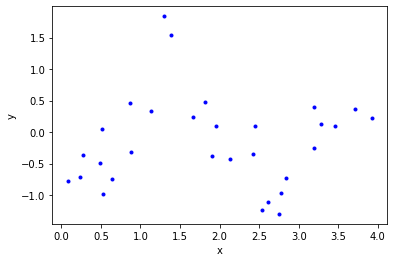

In [2]:
np.random.seed(2019*2)
X, y = gen_data(n_samples=30, x_scale=[0,4])
X_val, y_val = gen_data(n_samples=1000, x_scale=[0,4])
X_test, y_test = gen_data(n_samples=1000, x_scale=[0,4])

print(X.shape, y.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# Plot only the training data!
plot_data(X,y)

## Método do gradiente

Resgate a classe do modelo que você implementou no exercício anterior. Primeiramente, iremos reorganizá-la para torná-la **parcialmente** compatível com a biblioteca `sklearn`, bem como permitir um método de treinamento alternativo.

- Utilize a classe abaixo, substituindo na função `__fit_ne` a sua função `fit` implementada anteriormente.
- Note que a função `add_powers` foi eliminada (bem como o argumento `d` da inicialização do modelo), sendo substituída pela função `add_ones` (que simplesmente adiciona uma coluna de 1's). Ou seja, nosso modelo deve implementar puramente uma regressão linear (com regularização L2), sem atributos adicionais. Caso desejemos atributos polinomiais, poderemos usar a classe `PolynomialFeatures` do sklearn. A única vantagem do nosso modelo de regressão próprio em relação ao `Ridge` é permitir utilizar um método de treinamento diferente.

In [3]:
class Model():
    # Linear regression with L2 regularization
    def __init__(self, lamb=0, solver='ne', lr=1, maxiter=1000, tol=1e-5):
        # Initialization
        self.lamb = lamb
        self.solver = solver
        self.lr = lr
        self.maxiter = maxiter
        self.tol = tol
        return
    
    def __add_ones(self, X):
        # Add column of ones
        X_new = np.c_[np.ones(X.shape[0]), X]
        return X_new
    
    def __fit_ne(self, X, y):
        # Fit by normal equation
        L = np.diag(np.concatenate(([0],np.ones(X.shape[1])),axis=0))
        X = self.__add_ones(X)
        assert np.linalg.matrix_rank(X.T @ X + self.lamb*L) == X.shape[1], 'Singular matrix'
        self.w = np.linalg.inv(X.T @ X + self.lamb*L)@X.T@y
        return

    def __fit_gd(self, X, y):
        # Fit by gradient descent
      
        y = y.reshape(X.shape[0],1)
        L = np.diag(np.concatenate(([0],np.ones(X.shape[1])),axis=0))
        X = self.__add_ones(X)
        m = X.shape[0]
        self.J_history = []
        self.w = np.zeros(X.shape[1])
        self.w=self.w.reshape(X.shape[1],1)
        
        for i in range(self.maxiter):
            
            grad = (2/m)*X.T @ ((X @ self.w) - y)
            self.J_history.append((1/m)*(np.linalg.norm((X@self.w)-y))**2 - (self.lamb/m)*np.linalg.norm(self.w)**2)
            
            if np.linalg.norm(grad)>self.tol:
                self.w = ((np.eye(X.shape[1])-self.lamb*self.lr*(2/m)*L) @ self.w)-self.lr*grad
            else:
                print('Tol achieved in',i+1,'iterations')
                break
        return

    def fit(self, X, y):
        if self.solver == 'gd':
            self.__fit_gd(X, y)
        elif self.solver == 'ne':
            self.__fit_ne(X, y)
        else:
            raise RuntimeError('Unknown solver')
        return self

    def predict(self, X):
        X = self.__add_ones(X)
        y_pred = X @ self.w
        return y_pred
    

- Mova a função `mse` para fora da classe, caso contrário não poderemos acessá-la dentro de um `Pipeline`.

In [4]:
import sklearn as skl
import sklearn.metrics

def mse(model, X, y):
    return skl.metrics.mean_squared_error(y,model.predict(X))

- Complete a função `__fit_gd` implementando o método do gradiente. Utilize os parâmetros `self.lr` (taxa de aprendizado), `self.maxiter` (número máximo de iterações) e `self.tol` (critério de parada para a norma do gradiente). Além de calcular `self.w`, sua função deve criar também uma lista, `self.J_history`, contendo os valores da função custo (regularizada) a cada iteração, a qual será usada para monitorar o treinamento e analisar a taxa de aprendizado.
- Treine o modelo (usando `solver='gd'`), trace o gráfico de `J_history` e escolha uma boa taxa de aprendizado. Quantas iterações foram necessárias para convergência?
- Calcule o MSE de treinamento e de validação e compare-os com os obtidos pela solução analítica.

Tol achieved in 398 iterations
MSE no conj. de treinamento para o método GRADIENTE: 0.5172643521186309
MSE no conj. de treinamento para o método EQ. NORMAL: 0.5172643520113678
MSE no conj. de validação para o método GRADIENTE: 0.6010576299793896
MSE no conj. de validação para o método EQ. NORMAL: 0.601058546144856


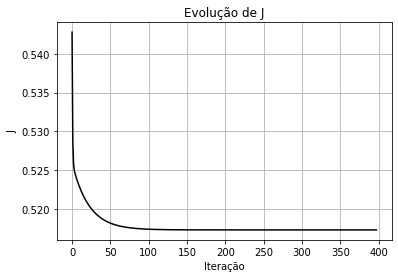

In [5]:
import matplotlib.pyplot as plt

gradient = Model(solver = 'gd', lr = 0.05)
gradient.fit(X,y)

normaleq = Model(solver = 'ne')
normaleq.fit(X,y)

plt.plot(gradient.J_history, 'k')
plt.title('Evolução de J')
plt.ylabel('J')
plt.xlabel('Iteração')
plt.grid(1)

mse_grad_trein = mse(gradient, X, y)
mse_grad_val = mse(gradient, X_val, y_val)
mse_ne_trein = mse(normaleq, X, y)
mse_ne_val = mse(normaleq, X_val, y_val)

print('MSE no conj. de treinamento para o método GRADIENTE:', mse_grad_trein)
print('MSE no conj. de treinamento para o método EQ. NORMAL:', mse_ne_trein)
print('MSE no conj. de validação para o método GRADIENTE:', mse_grad_val)
print('MSE no conj. de validação para o método EQ. NORMAL:', mse_ne_val)


A diferença entre os métodos aparece apenas quando são consideradas muitas casas decimais. O método gradiente é mais útil quando estamos trabalhando com muitos dados, fazendo com que o custo computacional passe de $O(mn^{2})$ para $O(mn*maxiter)$.

## Adicionando atributos

- Adicione atributos polinomiais de graus `d=2` e `d=3`, usando o transformador `PolynomialFeatures` e a função `make_pipeline`. Verifique a dificuldade de convergência. Por que isso ocorre? Foi necessário alterar a taxa de aprendizado? E o número máximo de iterações?
- Assim como anteriormente, compare o MSE obtido com a da solução analítica.
- Para fins de análise, calcule a hessiana da função custo (dentro do treinamento) e utilize a função `np.linalg.cond()` para estimar o grau de condicionamento da matriz.

#### Dica

- Não há necessidade de incluir o termo constante nos atributos adicionados, uma vez que o modelo já implementa a adição de coluna de 1's. Assim, utilize `PolynomialFeatures(d,include_bias=False)`

Para $d = 2$:

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

poly_2 = PolynomialFeatures(degree = 2, include_bias = False)

gradient_2 = make_pipeline(poly_2, Model(solver='gd', maxiter=5000, lr=0.02))
normaleq_2 = make_pipeline(poly_2, Model(solver='ne'))

gradient_2.fit(X,y)
normaleq_2.fit(X,y)

mse_grad2_trein = mse(gradient_2, X, y)
mse_grad2_val = mse(gradient_2, X_val, y_val)
mse_ne2_trein = mse(normaleq_2, X, y)
mse_ne2_val = mse(normaleq_2, X_val, y_val)

print('MSE no conj. de treinamento para o método GRADIENTE:', mse_grad2_trein)
print('MSE no conj. de treinamento para o método EQ. NORMAL:', mse_ne2_trein)
print('MSE no conj. de validação para o método GRADIENTE:', mse_grad2_val)
print('MSE no conj. de validação para o método EQ. NORMAL:', mse_ne2_val)

Tol achieved in 4097 iterations
MSE no conj. de treinamento para o método GRADIENTE: 0.511995770109261
MSE no conj. de treinamento para o método EQ. NORMAL: 0.5119957696213476
MSE no conj. de validação para o método GRADIENTE: 0.6117979400086987
MSE no conj. de validação para o método EQ. NORMAL: 0.6118028788933286


Para $d = 3$:

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

poly_3 = PolynomialFeatures(degree = 3, include_bias = False)

gradient_3 = make_pipeline(poly_3, Model(solver='gd', maxiter=1000000, lr=0.001))
normaleq_3 = make_pipeline(poly_3, Model(solver='ne'))

gradient_3.fit(X,y)
normaleq_3.fit(X,y)

mse_grad3_trein = mse(gradient_3, X, y)
mse_grad3_val = mse(gradient_3, X_val, y_val)
mse_ne3_trein = mse(normaleq_3, X, y)
mse_ne3_val = mse(normaleq_3, X_val, y_val)

print('MSE no conj. de treinamento para o método GRADIENTE:', mse_grad3_trein)
print('MSE no conj. de treinamento para o método EQ. NORMAL:', mse_ne3_trein)
print('MSE no conj. de validação para o método GRADIENTE:', mse_grad3_val)
print('MSE no conj. de validação para o método EQ. NORMAL:', mse_ne3_val)

Tol achieved in 554776 iterations
MSE no conj. de treinamento para o método GRADIENTE: 0.3254984509666064
MSE no conj. de treinamento para o método EQ. NORMAL: 0.32549844787202004
MSE no conj. de validação para o método GRADIENTE: 0.33495164991302695
MSE no conj. de validação para o método EQ. NORMAL: 0.3349465849157482


## Escalonamento de atributos

- Implemente a normalização (escalonamento) de atributos conforme vista em sala, a qual consiste de:
 - Subtração da média do atributo, para que passe a ter média nula
 - Divisão pelo desvio padrão do atributo, para que passe a ter variância unitária
 
Esse tipo de normalização também é chamado em alguns contextos de padronização (_standardization_), no sentido de resultar na mesma média (0) e variância (1) de uma variável aleatória gaussiana padrão (_standard_), em contraste com outros tipos de normalização (por exemplo, reescalonamento para a escala [0,1]).

- Para isso, complete a classe abaixo. Caso deseje confirmar se sua implementação está correta, compare com o transformador `StandardScaler` do módulo `sklearn.preprocessing`.

In [13]:
class MyStandardScalar():
    def fit(self, X, y=None):
        # Compute and store scaler parameters
        X_mean = np.mean(X,axis=0)
        X_std = np.std(X,axis=0)
        self.X_mean = X_mean
        self.X_std = X_std
        return
        
        return self
    def transform(self, X, y=None):
        # Scale features
        X_new = (X - self.X_mean)/self.X_std
        return X_new

- Após implementar corretamente, verifique que seu escalonador funciona corretamente em um pipeline do `sklearn`. Em seguida, você pode ignorar sua implementação e passar a usar o `StandardScaler`.
- Refaça os mesmos passos da seção anterior e compare os resultados e o comportamento do algoritmo. Explique.
- (OPCIONAL) Experimente outros escalonadores do `sklearn`, como `MinMaxScaler` e `MaxAbsScaler`, e compare o desempenho obtido.

#### Dicas

- Funções úteis:

```python
np.mean(axis=0), np.std(axis=0)
```

- Revise as propriedades de broadcasting do NumPy, em particular em operações envolvendo matrizes e arrays 1D.
- Para depurar possíveis erros, lembre-se de verificar o `shape` dos arrays envolvidos.

## Ainda mais atributos

- Adicione atributos polinomiais de grau ainda maior. O que você observa?
- Você recomendaria o método do gradiente para um problema desse tipo? Ou seria melhor usar um método de segunda ordem? Explique.
- Ao invés de adicionar inúmeros atributos polinomiais, seja criativo: utilize poucos atributos que aproximem melhor o conjunto de treinamento. Lembre que você pode introduzir qualquer função que desejar. No `sklearn` isso pode ser feito utilizando a classe abaixo, a qual pode ser integrada em uma *pipeline*.

In [10]:
class MyFeatures():
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_new
        return X_new

# Conjunto de dados #2

O segundo conjunto de dados que usaremos consiste de dados sobre a venda de casas em King County, USA, entre maio de 2014 e maio de 2015. O objetivo é prever o preço de venda a partir de informações sobre a casa. Baixe o arquivo em

http://www.kaggle.com/harlfoxem/housesalesprediction/data

descompacte-o e salve-o numa subpasta `data`, i.e., o arquivo estará acessível em `data/kc_house_data.csv`

In [13]:
import pandas as pd
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Como variável de saída, $y$, utilize o **logaritmo** neperiano do preço de venda , `price`, i.e., `np.log(price)`. Desta forma o erro na predição de $y$ será função do erro _relativo_ na predição do preço, evitando dar peso excessivo aos preços mais altos. Como atributos, utilize apenas as 4 colunas após o preço de venda, i.e., `bedrooms`, `bathrooms`, `sqft_living` e `sqft_lot`.

In [14]:
# Removing outliers

df = df[df['bedrooms']<10]
df = df[df['bathrooms']<6]
df = df[df['sqft_living']<7000]
df = df[df['sqft_lot']<600e3]

data = df[['bedrooms','bathrooms','sqft_living','sqft_lot','price']].to_numpy()
X = data[:,:4]
y = np.log(data[:,4])
print(X.shape, y.shape)

(21560, 4) (21560,)


Separe o conjunto de dados aleatoriamente em conjuntos de treinamento, validação e teste, nas proporções 60%, 20% e 20%, respectivamente. Para isso, utilize a função `sklearn.model_selection.train_test_split()`.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=y_test.shape[0], random_state=0)
del(X,y) # just to make sure we will not use them by mistake. Or set X,y = X_train,y_train

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(12936, 4) (12936,)
(4312, 4) (4312,)
(4312, 4) (4312,)


Como função perda para o treinamento, utilize o erro quadrático, e, como métrica de avaliação do modelo, utilize a raiz quadrada do erro quadrático médio. Ambos são equivalentes, mas o segundo resulta em valores numa escala mais agradável para análise e mais fácil de interpretar. Para facilitar, utilize a função abaixo.

In [16]:
def rmse(model, X, y):
    return np.sqrt(skl.metrics.mean_squared_error(y,model.predict(X)))

## Exploração dos dados

Antes de escolher e começar a treinar um modelo, é útil fazer uma breve exploração dos dados. (Foi dessa exploração inicial que surgiu a ideia, por exemplo, de remover outliers, com aqueles valores específicos.) Para cada atributo, trace o gráfico da variável de saída em função do atributo, sobre o conjunto de treinamento. Observe as escalas das variáveis envolvidas e analise se há alguma dependência aparente entre as variáveis. Intuitivamente, qual atributo parece ser mais preditivo do preço do venda?

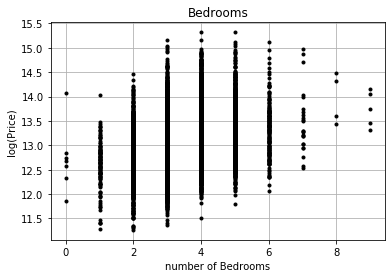

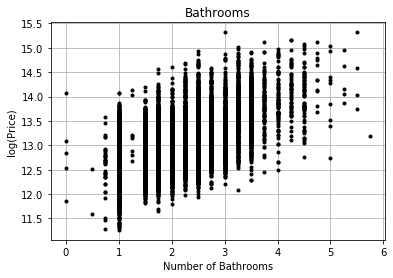

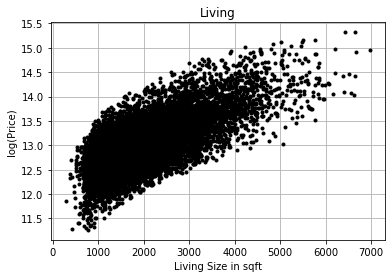

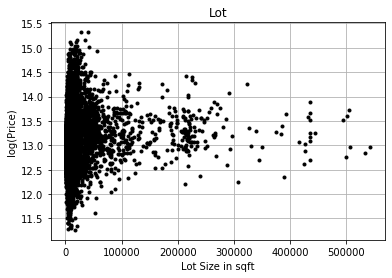

In [17]:

plt.figure('0')
plt.plot(X_train[:,0],y_train,'k.')
plt.title('Bedrooms')
plt.xlabel('number of Bedrooms')
plt.ylabel('log(Price)')
plt.grid(1)

plt.figure('1')
plt.plot(X_train[:,1],y_train,'k.')
plt.title('Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('log(Price)')
plt.grid(1)

plt.figure('2')
plt.plot(X_train[:,2],y_train,'k.')
plt.title('Living')
plt.xlabel('Living Size in sqft')
plt.ylabel('log(Price)')
plt.grid(1)

plt.figure('3')
plt.plot(X_train[:,3],y_train,'k.')
plt.title('Lot')
plt.xlabel('Lot Size in sqft')
plt.ylabel('log(Price)')
plt.grid(1)

O que se pode observar é uma correlação da área interna (living) com o preço.

## Regressão linear

Inicialmente você deve treinar um modelo de regressão linear sem regularização e calcular o RMSE da predição sobre o conjunto de treinamento e sobre o conjunto de validação. Fique à vontade para usar as funções do `sklearn`, não há necessidade de usar o método do gradiente.

Você diria que o modelo treinado sofre de underfitting, overfitting ou nenhum dos dois? Explique.

In [22]:
model = Model()
model.fit(X_train,y_train)
rmse_train = rmse(model,X_train,y_train)
model.fit(X_test,y_test)
rmse_test = rmse(model,X_test,y_test)
print("rmse train =", rmse_train)
print("rmse test =", rmse_test)

rmse train = 0.3730442212736104
rmse test = 0.3703569267453926


O modelo não apresentou overfitting pois o erro no conjunto de treino e de teste é muito semelhante.

## Aprimorando o modelo

Usando o que vimos até agora na disciplina, tente ao máximo melhorar o desempenho do modelo neste conjunto de dados. Use sua criatividade.

Utilizando normalização:

In [30]:
from sklearn import model_selection, preprocessing
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.pipeline import Pipeline

scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


lr = Ridge()
lr.fit(X_train,y_train)
lr.coef_

array([-7.71000549e-02,  5.24003978e-02,  4.21261110e-04, -4.51312331e-07])

In [31]:
lr.intercept_

12.327590383762239

In [33]:
acc = lr.score(X_test,y_test)
print("Accuracy: ", acc*100,"%")

Accuracy:  48.80626540116652 %
